## Import libraries

In [26]:
print(globals()["_dh"][0])

/mnt/d/Hakims/college/S2/tesis/id-g2p-medical-domain/modules/prn-gen/exp/id


In [1]:
import os
import random
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
%pip install jiwer

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
from jiwer import wer

## Variables

In [4]:
GRP_TYPE = "unigram" # @param ["unigram", "bigram", "trigram"]
ATTN_MODEL = "dot"
EMB_DIM = "64" # @param [16, 32, 64, 128, 256, 512]
HIDDEN_SIZE = "50" # @param [64, 128, 256, 512, 1024]
N_LAYERS = "1" # @param [1, 2]
DROPOUT_PROBA = .1

## Constants

In [5]:
# PyTorch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = (DEVICE.type == "cuda")
print(f"Using device: {DEVICE}")
BATCH_SIZE = 64

# Data preprocessing
SOS_TOKEN = 0
EOS_TOKEN = 1
PAD_TOKEN = 2
UNK_TOKEN = 3

# Directories
CURR_DIR = globals()["_dh"][0]
DATA_SOURCE_DIR = os.path.join(CURR_DIR, "../../data/ma")
DATA_DIR = os.path.join(CURR_DIR, "data")
if not os.path.exists(DATA_DIR) :
  os.mkdir(DATA_DIR)
shutil.copy(os.path.join(DATA_SOURCE_DIR, "train_converted.csv"), os.path.join(DATA_DIR, "train.csv"))
shutil.copy(os.path.join(DATA_SOURCE_DIR, "val_converted.csv"), os.path.join(DATA_DIR, "val.csv"))
shutil.copy(os.path.join(DATA_SOURCE_DIR, "test_converted.csv"), os.path.join(DATA_DIR, "test.csv"))
MODELS_DIR = os.path.join(CURR_DIR, "models")
if not os.path.exists(MODELS_DIR) :
  os.mkdir(MODELS_DIR)
MODELS_DIR = os.path.join(MODELS_DIR, GRP_TYPE)
if not os.path.exists(MODELS_DIR) :
  os.mkdir(MODELS_DIR)

Using device: cuda


## Preparing dataset

### `G2PDataset` torch dataset class definition

In [6]:
class G2PDataset(Dataset) :
  def __init__(self, graphemes_list, phonemes_list) -> None :
    assert len(graphemes_list) == len(phonemes_list)
    # Handle graphemes
    self.graphemes_list = graphemes_list
    self.grapheme2index = {}
    self.index2grapheme = {0: "<SOS>", 1: "<EOS>", 2:"<PAD>", 3:"<UNK>"}
    self.n_graphemes = 4
    for graphemes in graphemes_list :
      for grapheme in graphemes :
        self.add_grapheme(grapheme)
    i = 4
    for grapheme in sorted(self.grapheme2index) :
      self.grapheme2index[grapheme] = i
      self.index2grapheme[i] = grapheme
      i += 1
    # Handle phonemes
    self.phonemes_list = phonemes_list
    self.phoneme2index = {}
    self.index2phoneme = {0: "<SOS>", 1: "<EOS>", 2:"<PAD>"}
    self.n_phonemes = 3
    for phonemes in phonemes_list :
      for phoneme in phonemes :
        self.add_phoneme(phoneme)
    i = 3
    for phoneme in sorted(self.phoneme2index) :
      self.phoneme2index[phoneme] = i
      self.index2phoneme[i] = phoneme
      i += 1

  def add_grapheme(self, grapheme) :
    if grapheme not in self.grapheme2index :
      self.grapheme2index[grapheme] = self.n_graphemes
      self.index2grapheme[self.n_graphemes] = grapheme
      self.n_graphemes += 1

  def add_phoneme(self, phoneme) :
    if phoneme not in self.phoneme2index :
      self.phoneme2index[phoneme] = self.n_phonemes
      self.index2phoneme[self.n_phonemes] = phoneme
      self.n_phonemes += 1

  def __len__(self) :
    return len(self.graphemes_list)

  def __getitem__(self, index) -> str :
    graphemes = [self.grapheme2index.get(grapheme, UNK_TOKEN) for grapheme in self.graphemes_list[index]] + [EOS_TOKEN]
    phonemes = [self.phoneme2index[phoneme] for phoneme in self.phonemes_list[index]] + [EOS_TOKEN]
    return graphemes, phonemes

### Helper functions to prepare `train/val/test` set

In [7]:
def extract_graphemes(grapheme_syllable_sequence:str, grp_type:str) :
  word = ''.join(grapheme_syllable_sequence.split('.')).lower()
  # Unigram
  if grp_type == "unigram" :
    return [*word]
  # Bigram
  elif grp_type == "bigram" :
    if len(word) < 2 :
      return [word]
    return [word[i:i+2] for i in range(len(word)-1)]
  # Trigram
  elif grp_type == "trigram" :
    if len(word) < 3 :
      return [word]
    return [word[i:i+3] for i in range(len(word)-2)]

def extract_arpabet_phonemes(arpabet_phoneme_sequence:str) :
  return arpabet_phoneme_sequence.split()

In [8]:
def prepare_dataset(split_name:str, grp_type:str) :
  assert split_name in ["train", "val", "test"]
  assert grp_type in ["unigram", "bigram", "trigram"]
  print(f"Reading {split_name} entries ..")
  # Read the file and split into lines
  with open(os.path.join(DATA_DIR, f"{split_name}.csv"), encoding="utf-8") as f_csv :
    next(f_csv, None)
    # Split every row into pairs
    pairs = [[s.strip('\n') for s in row.split(',')] for row in f_csv]
    # Accumulate all lines into two graphemes and phonemes lists
    graphemes_list = [extract_graphemes(pair[0], grp_type) for pair in pairs] # Split grapheme as desired
    phonemes_list = [extract_arpabet_phonemes(pair[-1]) for pair in pairs]
    # Create the G2PDataset object
    g2p_dataset = G2PDataset(graphemes_list, phonemes_list)
  return g2p_dataset, pairs

In [9]:
train_g2p_dataset, train_pairs = prepare_dataset("train", grp_type=GRP_TYPE)
val_g2p_dataset, val_pairs = prepare_dataset("val", grp_type=GRP_TYPE)
test_g2p_dataset, test_pairs = prepare_dataset("test", grp_type=GRP_TYPE)
pairs = train_pairs + val_pairs + test_pairs

# Equalize grapheme and phoneme mappings for val and test set
## Valid set
val_g2p_dataset.grapheme2index = train_g2p_dataset.grapheme2index
val_g2p_dataset.index2grapheme = train_g2p_dataset.index2grapheme
val_g2p_dataset.n_graphemes = train_g2p_dataset.n_graphemes
val_g2p_dataset.phoneme2index = train_g2p_dataset.phoneme2index
val_g2p_dataset.index2phoneme = train_g2p_dataset.index2phoneme
val_g2p_dataset.n_phonemes = train_g2p_dataset.n_phonemes
## Test set
test_g2p_dataset.grapheme2index = train_g2p_dataset.grapheme2index
test_g2p_dataset.index2grapheme = train_g2p_dataset.index2grapheme
test_g2p_dataset.n_graphemes = train_g2p_dataset.n_graphemes
test_g2p_dataset.phoneme2index = train_g2p_dataset.phoneme2index
test_g2p_dataset.index2phoneme = train_g2p_dataset.index2phoneme
test_g2p_dataset.n_phonemes = train_g2p_dataset.n_phonemes

# Find the maximum output sequence length among graphemes and phonemes across all datasets
MAX_LENGTH = -999
for graphemes in train_g2p_dataset.graphemes_list :
  if MAX_LENGTH < len(graphemes) :
    MAX_LENGTH = len(graphemes)
for phonemes in train_g2p_dataset.phonemes_list :
  if MAX_LENGTH < len(phonemes) :
    MAX_LENGTH = len(phonemes)
for graphemes in val_g2p_dataset.graphemes_list :
  if MAX_LENGTH < len(graphemes) :
    MAX_LENGTH = len(graphemes)
for phonemes in val_g2p_dataset.phonemes_list :
  if MAX_LENGTH < len(phonemes) :
    MAX_LENGTH = len(phonemes)
for graphemes in test_g2p_dataset.graphemes_list :
  if MAX_LENGTH < len(graphemes) :
    MAX_LENGTH = len(graphemes)
for phonemes in test_g2p_dataset.phonemes_list :
  if MAX_LENGTH < len(phonemes) :
    MAX_LENGTH = len(phonemes)

Reading train entries ..
Reading val entries ..
Reading test entries ..


In [10]:
torch.save(train_g2p_dataset.index2grapheme, os.path.join(MODELS_DIR, "id2grp.pth"))
torch.save(train_g2p_dataset.index2phoneme, os.path.join(MODELS_DIR, "id2phn.pth"))

# Custom Collate function (for padding)
def collate_fn(batch) :
  # batch: [(input_seq, target_seq), ...]
  graphemes, phonemes = zip(*batch)
  # Pad sequences
  graphemes_padded = pad_sequence([torch.tensor(x) for x in graphemes], padding_value=PAD_TOKEN)
  phonemes_padded = pad_sequence([torch.tensor(y) for y in phonemes], padding_value=PAD_TOKEN)
  return graphemes_padded, phonemes_padded

train_dataloader = DataLoader(train_g2p_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
valid_dataloader = DataLoader(val_g2p_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)
test_dataloader = DataLoader(test_g2p_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

## Turning grapheme and phoneme data to Tensors/Variables

In [11]:
def indexes_from_word(dataset, word, grp_type) :
  assert grp_type in ["unigram", "bigram", "trigram"]
  word = word.lower()
  if grp_type == "unigram" :
    graphemes = [*word]
  elif grp_type == "bigram" :
    graphemes = [word[i:i+2] for i in range(len(word)-1)] if len(word)>=2 else [word]
  elif grp_type == "trigram" :
    graphemes = [word[i:i+3] for i in range(len(word)-2)] if len(word)>=3 else [word]
  return [dataset.grapheme2index.get(grapheme, UNK_TOKEN) for grapheme in graphemes] + [EOS_TOKEN]

def variable_from_word(dataset, word, grp_type) :
  indexes = indexes_from_word(dataset, word, grp_type)
  var = torch.LongTensor(indexes).view(-1, 1).to(DEVICE)
  return var

In [12]:
print(indexes_from_word(train_g2p_dataset, "menguncinya", grp_type=GRP_TYPE))
# print(variable_from_word(train_g2p_dataset, "menguncinya", grp_type=GRP_TYPE))

[18, 10, 19, 12, 26, 19, 8, 14, 19, 29, 6, 1]


In [13]:
print(train_g2p_dataset, train_dataloader.dataset[0])
print(train_g2p_dataset[0])
print(train_dataloader.dataset[0])
print("train grp", len(train_g2p_dataset.index2grapheme), train_g2p_dataset.index2grapheme)
print("valid grp", len(val_g2p_dataset.index2grapheme), val_g2p_dataset.index2grapheme)
print("test grp", len(test_g2p_dataset.index2grapheme), test_g2p_dataset.index2grapheme)
print("train phn", len(train_g2p_dataset.index2phoneme), train_g2p_dataset.index2phoneme)
print("valid phn", len(val_g2p_dataset.index2phoneme), val_g2p_dataset.index2phoneme)
print("test phn", len(test_g2p_dataset.index2phoneme), test_g2p_dataset.index2phoneme)
print(len(train_g2p_dataset.grapheme2index), train_g2p_dataset.grapheme2index)
print(len(val_g2p_dataset.grapheme2index), val_g2p_dataset.grapheme2index)
print(len(test_g2p_dataset.grapheme2index), test_g2p_dataset.grapheme2index)
print(len(train_g2p_dataset.phoneme2index), train_g2p_dataset.phoneme2index)
print(len(val_g2p_dataset.phoneme2index), val_g2p_dataset.phoneme2index)
print(len(test_g2p_dataset.phoneme2index), test_g2p_dataset.phoneme2index)

<__main__.G2PDataset object at 0x7fd6145c72b0> ([5, 5, 19, 29, 6, 1], [23, 3, 1])
([5, 5, 19, 29, 6, 1], [23, 3, 1])
([5, 5, 19, 29, 6, 1], [23, 3, 1])
train grp 31 {0: '<SOS>', 1: '<EOS>', 2: '<PAD>', 3: '<UNK>', 4: "'", 5: '-', 6: 'a', 7: 'b', 8: 'c', 9: 'd', 10: 'e', 11: 'f', 12: 'g', 13: 'h', 14: 'i', 15: 'j', 16: 'k', 17: 'l', 18: 'm', 19: 'n', 20: 'o', 21: 'p', 22: 'q', 23: 'r', 24: 's', 25: 't', 26: 'u', 27: 'v', 28: 'w', 29: 'y', 30: 'z'}
valid grp 31 {0: '<SOS>', 1: '<EOS>', 2: '<PAD>', 3: '<UNK>', 4: "'", 5: '-', 6: 'a', 7: 'b', 8: 'c', 9: 'd', 10: 'e', 11: 'f', 12: 'g', 13: 'h', 14: 'i', 15: 'j', 16: 'k', 17: 'l', 18: 'm', 19: 'n', 20: 'o', 21: 'p', 22: 'q', 23: 'r', 24: 's', 25: 't', 26: 'u', 27: 'v', 28: 'w', 29: 'y', 30: 'z'}
test grp 31 {0: '<SOS>', 1: '<EOS>', 2: '<PAD>', 3: '<UNK>', 4: "'", 5: '-', 6: 'a', 7: 'b', 8: 'c', 9: 'd', 10: 'e', 11: 'f', 12: 'g', 13: 'h', 14: 'i', 15: 'j', 16: 'k', 17: 'l', 18: 'm', 19: 'n', 20: 'o', 21: 'p', 22: 'q', 23: 'r', 24: 's', 25: 't

## Model definitions

### Encoder

In [14]:
class Encoder(nn.Module) :
  def __init__(self, input_size, emb_dim, hidden_size, n_layers=1) -> None :
    super(Encoder, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.n_layers = n_layers

    self.embedding = nn.Embedding(input_size, emb_dim).to(DEVICE)
    self.gru = nn.GRU(emb_dim, hidden_size, n_layers, batch_first=False).to(DEVICE)

  def forward(self, token_inputs, hidden) :
    embedded = self.embedding(token_inputs) # [seq_len, batch_size, emb_dim]
    output, hidden = self.gru(embedded, hidden)
    return output, hidden # output: [seq_len, batch_size, hidden_size]

  def init_hidden(self, batch_size=1) :
    hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(DEVICE)
    # hidden shape: [n_layers, batch_size, hidden_size]
    return hidden

### Attention

In [15]:
class Attn(nn.Module) :
  def __init__(self, method, hidden_size) -> None :
    super(Attn, self).__init__()
    self.method = method
    self.hidden_size = hidden_size

    if self.method == "general" :
      self.attn = nn.Linear(self.hidden_size, hidden_size).to(DEVICE)
    elif self.method == "concat" :
      self.attn = nn.Linear(self.hidden_size*2, hidden_size).to(DEVICE)
      self.v = nn.Parameter(torch.FloatTensor(hidden_size)).to(DEVICE)

  def forward(self, hidden, encoder_outputs) :
    # hidden shape: [1, batch_size, hidden_size]
    # encoder_outputs shape: [seq_len, batch_size, hidden_size]

    if self.method == "dot" :
      # Vectorized dot product for all positions in the sequence
      attn_energies = torch.sum(hidden * encoder_outputs, dim=2) # [seq_len, batch_size]
    elif self.method == "general" :
      energy = self.attn(encoder_outputs) # [seq_len, batch_size, hidden_size]
      attn_energies = torch.sum(hidden * energy, dim=2)
    elif self.method == "concat" :
      hidden_expanded = hidden.expand(encoder_outputs.size(0), -1, -1) # [seq_len, batch_size, hidden_size]
      energy = self.attn(torch.cat((hidden_expanded, encoder_outputs), 2)) # [seq_len, batch_size, hidden_size]
      attn_energies = torch.sum(self.v * energy, dim=2)

    # Normalize energies to weights
    attn_weights = F.softmax(attn_energies, dim=0) # [seq_len, batch_size]
    return attn_weights.transpose(0, 1).unsqueeze(1) # [batch_size, 1, seq_len]

### Decoder

In [16]:
class Decoder(nn.Module) :
  def __init__(self, attn_model, emb_dim, hidden_size, output_size, n_layers=1, dropout_proba=.1) -> None :
    super(Decoder, self).__init__()
    self.attn_model = attn_model
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers
    self.dropout_proba = dropout_proba

    # Define layers
    self.embedding = nn.Embedding(output_size, emb_dim).to(DEVICE)
    self.gru = nn.GRU(emb_dim + hidden_size, hidden_size, n_layers, dropout=dropout_proba, batch_first=False).to(DEVICE)
    self.out = nn.Linear(hidden_size*2, output_size).to(DEVICE)

    # Choose attention model
    if attn_model != "none" :
      self.attn = Attn(attn_model, hidden_size).to(DEVICE)

  def forward(self, token_input, last_context, last_hidden, encoder_outputs) :
    # token_input shape: [1, batch_size]
    # last_context shape: [batch_size, hidden_size]
    # last_hidden shape: [n_layers, batch_size, hidden_size]
    # encoder_outputs shape: [seq_len, batch_size, hidden]
    # Get the embedding of the current input token (last output token)

    embedded = self.embedding(token_input) # [1, batch_size, emb_dim]
    # Combine embedded input token and last context, run through RNN
    rnn_input = torch.cat((embedded, last_context.unsqueeze(0)), dim=2) # [1, batch_size, emb_dim + hidden_size]
    # GRU forward
    rnn_output, hidden = self.gru(rnn_input, last_hidden) # rnn_output: [1, batch_size, hidden_size]

    # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
    attn_weights = self.attn(rnn_output, encoder_outputs) # [batch_size, 1, seq_len]
    context = torch.bmm(attn_weights, encoder_outputs.transpose(0, 1)) # [batch_size, 1, hidden_size]
    context = context.transpose(0, 1) # [1, batch_size, hidden_size]

    # Final output layer (next token prediction) using the RNN hidden state and context vector
    rnn_output = rnn_output.squeeze(0)  # [batch_size, hidden_size]
    context = context.squeeze(0)        # [batch_size, hidden_size]
    output = torch.cat((rnn_output, context), dim=1) # [batch_size, hidden_size * 2]
    output = F.log_softmax(self.out(output), dim=1) # [batch_size, output_size]

    # Return final output, hidden state, and attention weights (for visualization)
    return output, context, hidden, attn_weights

## Technical check

In [17]:
# testing params
batch_size = 3
input_size = 100
emb_dim = 25
hidden_size = 15
n_layers = 1

# Init models
encoder_test = Encoder(input_size, emb_dim, hidden_size, n_layers)
decoder_test = Decoder("dot", emb_dim, hidden_size, output_size=input_size, n_layers=n_layers)
# Test encoder
encoder_hidden = encoder_test.init_hidden(batch_size=batch_size)
print("Encoder hidden shape:", encoder_hidden.shape)
# Test input (seq_len=4, batch_size=3)
input_batch = torch.LongTensor([[1,4,7], [2,5,8], [3,6,9], [4,7,10]]).to(DEVICE)
print("Input batch shape:", input_batch.shape)

encoder_outputs, encoder_hidden = encoder_test(input_batch, encoder_hidden)
print("Encoder outputs shape:", encoder_outputs.shape)
print("Encoder hidden shape:", encoder_hidden.shape)

# Test decoder
decoder_input = torch.LongTensor([[SOS_TOKEN] * batch_size]).to(DEVICE) # (1, batch_size)
decoder_context = torch.zeros(batch_size, hidden_size).to(DEVICE) # (batch_size, hidden_size)
decoder_hidden = encoder_hidden
for di in range(2) :
  decoder_output, decoder_context, decoder_hidden, attn = decoder_test(
      decoder_input,
      decoder_context,
      decoder_hidden,
      encoder_outputs
  )
  print(f"Step {di}:")
  print("Decoder output shape:", decoder_output.shape) # [batch_size, output_size]
  print("Decoder context shape:", decoder_context.shape)
  print("Decoder hidden shape:", decoder_hidden.shape) # [n_layers, batch_size, hidden_size]
  print("Attention shape:", attn.shape) # [batch_size, 1, seq_len]
  decoder_input = torch.argmax(decoder_output, dim=1).unsqueeze(0) # Greedy decoding

del encoder_test
del decoder_test

/home/ahmadnaufalhakim/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Encoder hidden shape: torch.Size([1, 3, 15])
Input batch shape: torch.Size([4, 3])
Encoder outputs shape: torch.Size([4, 3, 15])
Encoder hidden shape: torch.Size([1, 3, 15])
Step 0:
Decoder output shape: torch.Size([3, 100])
Decoder context shape: torch.Size([3, 15])
Decoder hidden shape: torch.Size([1, 3, 15])
Attention shape: torch.Size([3, 1, 4])
Step 1:
Decoder output shape: torch.Size([3, 100])
Decoder context shape: torch.Size([3, 15])
Decoder hidden shape: torch.Size([1, 3, 15])
Attention shape: torch.Size([3, 1, 4])


## Helper functions (for training log)

In [18]:
import time
import math
import matplotlib.pyplot as plt
plt.switch_backend("agg")
import matplotlib.ticker as ticker
%matplotlib inline
import numpy as np

def as_minutes(seconds) :
  minutes = math.floor(seconds/60)
  seconds -= minutes*60
  return f"{minutes}m {round(seconds, 2)}s"

def time_since(since, percent) :
  now = time.time()
  seconds = now - since
  eta_seconds = seconds/(percent)
  remaining_seconds = eta_seconds - seconds
  return f"{as_minutes(seconds)} (- {as_minutes(remaining_seconds)})"

## Train and validation script

In [19]:
teacher_forcing_ratio = .5

def train_batch(input_batch, target_batch, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion) :
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  input_batch = input_batch.to(DEVICE)
  target_batch = target_batch.to(DEVICE)

  batch_size = input_batch.size(1)
  # Forward through encoder
  encoder_hidden = encoder.init_hidden(batch_size)
  encoder_outputs, encoder_hidden = encoder(input_batch, encoder_hidden)
  # Prepare decoder inputs
  decoder_input = torch.LongTensor([[SOS_TOKEN] * batch_size]).to(DEVICE)
  decoder_context = torch.zeros(batch_size, decoder.hidden_size).to(DEVICE)
  decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder

  loss = 0
  for di in range(target_batch.size(0)) :
    decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(
      decoder_input, decoder_context, decoder_hidden, encoder_outputs
    )
    # # Debug: check for nan
    # if torch.isnan(criterion(decoder_output, target_batch[di])).any() :
    #   print("nan detected in decoder_output at step", di)
    #   print(f"step {di}/{target_batch.size(0)-1}")
    #   print(f"{di-1}:\t{target_batch[di-1]}")
    #   for i in range(di, target_batch.size(0)) :
    #     print(f"{i}:\t{target_batch[i]}")
    #   print(target_batch)
    #   print(decoder_output.shape, target_batch[di].shape, criterion(decoder_output, target_batch[di]))
    # Calculate loss for this step (sum over batch)
    loss += criterion(decoder_output, target_batch[di])
    # Teacher forcing
    decoder_input = target_batch[di].unsqueeze(0) if random.random() < teacher_forcing_ratio else decoder_output.argmax(1).unsqueeze(0)
    decoder_input = decoder_input.to(DEVICE)

  # Normalize loss
  loss /= target_batch.size(0)

  # Backpropagate loss
  loss.backward()
  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item()

def infer_batch(input_batch, target_batch, encoder, decoder, criterion) :
  input_batch = input_batch.to(DEVICE)
  target_batch = target_batch.to(DEVICE)

  batch_size = input_batch.size(1)
  # Forward through encoder
  encoder_hidden = encoder.init_hidden(batch_size)
  encoder_outputs, encoder_hidden = encoder(input_batch, encoder_hidden)
  # Prepare decoder inputs
  decoder_input = torch.LongTensor([[SOS_TOKEN] * batch_size]).to(DEVICE)
  decoder_context = torch.zeros(batch_size, decoder.hidden_size).to(DEVICE)
  decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder

  loss = 0
  for di in range(target_batch.size(0)) :
    decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(
        decoder_input, decoder_context, decoder_hidden, encoder_outputs
      )
    # Calculate loss for this step (sum over batch)
    loss += criterion(decoder_output, target_batch[di])
    # Greedy decoding without teacher forcing
    topi = decoder_output.argmax(1)
    decoder_input = topi.unsqueeze(0).detach() # detach from history

  # Normalize loss
  loss /= target_batch.size(0)

  return loss.item()

## Initialize model

In [20]:
attn_model = ATTN_MODEL
emb_dim = EMB_DIM
hidden_size = HIDDEN_SIZE
n_layers = N_LAYERS
dropout_proba = DROPOUT_PROBA

# Initialize models
encoder = Encoder(train_g2p_dataset.n_graphemes, int(emb_dim), int(hidden_size), int(n_layers))
decoder = Decoder(attn_model, int(emb_dim), int(hidden_size), train_g2p_dataset.n_phonemes, int(n_layers), dropout_proba=dropout_proba)
n_encoder_parameters = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
n_decoder_parameters = sum(p.numel() for p in decoder.parameters() if p.requires_grad)

print(f"attn_model: {attn_model}")
print(f"emb_dim: {emb_dim}")
print(f"hidden_size: {hidden_size}")
print(f"n_layers: {n_layers}")
print(f"Encoder has a total number of {n_encoder_parameters} parameters")
print(f"Decoder has a total number of {n_decoder_parameters} parameters")
print(f"Total number of all parameters is {n_encoder_parameters+n_decoder_parameters}")

# Move models to GPU
encoder = encoder.to(DEVICE)
decoder = decoder.to(DEVICE)

# Learning rate and weight decay parameters
learning_rate = .001
weight_decay = 1e-5
# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.NLLLoss(ignore_index=PAD_TOKEN)

# Early stopping parameters
patience = 999
epochs_without_improvement = 0
# Learning rate scheduling
encoder_scheduler = optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, factor=.5)
decoder_scheduler = optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, factor=.5)

/home/ahmadnaufalhakim/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


attn_model: dot
emb_dim: 64
hidden_size: 50
n_layers: 1
Encoder has a total number of 19384 parameters
Decoder has a total number of 30840 parameters
Total number of all parameters is 50224


## Run the training script

In [21]:
# Training configurations
n_epochs = 100
# Keep track of time elapsed and running averages
train_losses = []
val_losses = []
# Keep track of the best validation set loss
best_val_loss = float("inf")

start = time.time()
for epoch in range(1, n_epochs+1) :
  # Set both encoder and decoder to training mode
  encoder.train()
  decoder.train()
  print(f"Training for epoch {epoch} has started (lr={encoder_optimizer.param_groups[0]['lr']}). Found {len(train_dataloader)} batch(es).")
  # Training
  total_train_loss = 0
  total_train_tokens = 0
  for batch, (grps, phns) in enumerate(train_dataloader) :
    # Count tokens (excluding padding)
    total_train_tokens += (phns!=PAD_TOKEN).sum().item()
    # Train and get loss
    unweighted_train_loss = train_batch(grps, phns, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    # Track train loss for logging
    total_train_loss += unweighted_train_loss * (phns!=PAD_TOKEN).sum().item()

  # Set both encoder and decoder to evaluation mode
  encoder.eval()
  decoder.eval()
  # Validation
  with torch.no_grad() :
    total_val_loss = 0
    total_val_tokens = 0
    for grps, phns in valid_dataloader :
      # Count tokens (excluding padding)
      total_val_tokens += (phns!=PAD_TOKEN).sum().item()
      # Infer and get loss
      val_loss = infer_batch(grps, phns, encoder, decoder, criterion)
      # Track val loss for logging
      total_val_loss += val_loss * (phns!=PAD_TOKEN).sum().item()

  # Calculate epoch metrics
  avg_train_loss = total_train_loss/total_train_tokens
  avg_val_loss = total_val_loss/total_val_tokens
  print(f"Epoch {epoch} finished in {time_since(start, epoch/n_epochs)} ({epoch} {epoch*100/n_epochs}%). train avg loss: {round(avg_train_loss, 4)}, val avg loss: {round(avg_val_loss, 4)}")

  # Update schedulers based on validation loss
  encoder_scheduler.step(avg_val_loss)
  decoder_scheduler.step(avg_val_loss)

  # Save the losses for visualization
  train_losses.append(avg_train_loss)
  val_losses.append(avg_val_loss)

  # Save the model if the validation loss is better than the previous iterations' validation loss
  if avg_val_loss < best_val_loss :
    epochs_without_improvement = 0
    if epoch > 1 :
      previous_best_encoder = [f for f in os.listdir(MODELS_DIR) if f.startswith(f"FIN-encoder-wdecay_1e_5-attn_{attn_model}-emb_{emb_dim}-hddn_{hidden_size}-layers_{n_layers}")][0]
      previous_best_decoder = [f for f in os.listdir(MODELS_DIR) if f.startswith(f"FIN-decoder-wdecay_1e_5-attn_{attn_model}-emb_{emb_dim}-hddn_{hidden_size}-layers_{n_layers}")][0]
      os.remove(os.path.join(MODELS_DIR, previous_best_encoder))
      os.remove(os.path.join(MODELS_DIR, previous_best_decoder))
    torch.save(encoder.state_dict(), os.path.join(MODELS_DIR, f"FIN-encoder-wdecay_1e_5-attn_{attn_model}-emb_{emb_dim}-hddn_{hidden_size}-layers_{n_layers}-epoch_{epoch}.pth"))
    torch.save(decoder.state_dict(), os.path.join(MODELS_DIR, f"FIN-decoder-wdecay_1e_5-attn_{attn_model}-emb_{emb_dim}-hddn_{hidden_size}-layers_{n_layers}-epoch_{epoch}.pth"))
    best_val_loss = avg_val_loss
  else :
    epochs_without_improvement += 1
    if epochs_without_improvement >= patience :
      print(f"Early stopping after {epoch} epochs")
      break

Training for epoch 1 has started (lr=0.001). Found 357 batch(es).
Epoch 1 finished in 0m 10.67s (- 17m 36.39s) (1 1.0%). train avg loss: 2.0037, val avg loss: 1.9689
Training for epoch 2 has started (lr=0.001). Found 357 batch(es).
Epoch 2 finished in 0m 20.28s (- 16m 33.91s) (2 2.0%). train avg loss: 1.2119, val avg loss: 1.2656
Training for epoch 3 has started (lr=0.001). Found 357 batch(es).
Epoch 3 finished in 0m 28.24s (- 15m 13.07s) (3 3.0%). train avg loss: 0.6192, val avg loss: 0.8814
Training for epoch 4 has started (lr=0.001). Found 357 batch(es).
Epoch 4 finished in 0m 36.71s (- 14m 41.12s) (4 4.0%). train avg loss: 0.3752, val avg loss: 0.7199
Training for epoch 5 has started (lr=0.001). Found 357 batch(es).
Epoch 5 finished in 0m 45.96s (- 14m 33.2s) (5 5.0%). train avg loss: 0.2505, val avg loss: 0.5715
Training for epoch 6 has started (lr=0.001). Found 357 batch(es).
Epoch 6 finished in 0m 55.04s (- 14m 22.24s) (6 6.0%). train avg loss: 0.1789, val avg loss: 0.4579
Train

## Visualize training loss

<Figure size 640x480 with 0 Axes>

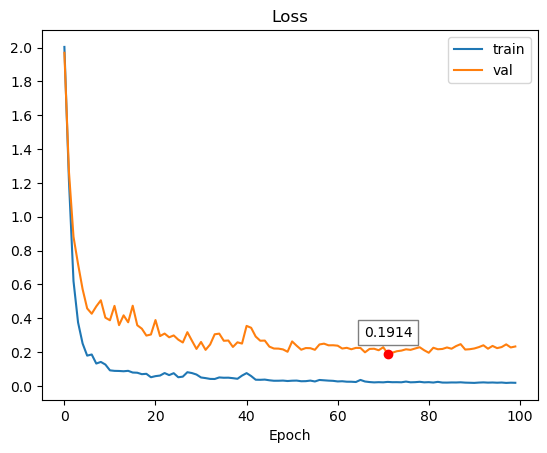

In [27]:
def show_plot(**kwargs) :
  plt.figure()
  fig, ax = plt.subplots()
  # This locator puts ticks at regular intervals
  loc = ticker.MultipleLocator(base=.2)
  ax.yaxis.set_major_locator(loc)
  plt.title("Loss")
  legends = []
  for k, v in kwargs.items() :
    plt.plot(v)
    plt.xlabel("Epoch")
    legends.append(k)
    if k == "val" :
      # Find the minimum value and its index
      min_value = min(v)
      min_index = v.index(min_value)
      # Plot a red dot at the minimum value
      plt.plot(min_index, min_value, "ro")
      # Add text box in the middle of the plot showing the minimum value
      plt.text(min_index-5.25, min_value+.1, f"{min_value:.4f}", bbox=dict(facecolor="white", alpha=.5))
  plt.legend(legends)

show_plot(train=train_losses, val=val_losses)

## Evaluate the model

### Helper functions to evaluate encoder-decoder attention model performance

In [23]:
def evaluate(word, max_length=MAX_LENGTH) :
  # Convert word to tensor with batch dimension
  input_variable = variable_from_word(test_g2p_dataset, word, grp_type=GRP_TYPE) # Already in [seq_len, 1]

  # Run through encoder
  encoder_hidden = encoder.init_hidden(batch_size=1)
  encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
  # Prepare decoder inputs
  decoder_input = torch.LongTensor([[SOS_TOKEN]]).to(DEVICE) # [1, 1]
  decoder_context = torch.zeros(1, decoder.hidden_size).to(DEVICE)
  decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder

  decoded_phonemes = []
  attentions = torch.zeros(max_length, max_length)
  for di in range(max_length) :
    decoder_output, decoder_context, decoder_hidden, attn_weights = decoder(
      decoder_input, decoder_context, decoder_hidden, encoder_outputs
    )
    # Store attention
    attentions[di, :attn_weights.size(2)] += attn_weights.squeeze(0).squeeze(0).cpu().data
    # Get most likely token
    topv, topi = decoder_output.data.topk(1)
    ni = topi[0][0]
    if ni.item() == EOS_TOKEN :
      decoded_phonemes.append("<EOS>")
      break
    else :
      decoded_phonemes.append(test_g2p_dataset.index2phoneme[ni.item()])
    # Next input is predicted token
    decoder_input = torch.LongTensor([[ni.item()]]).to(DEVICE)

  return decoded_phonemes, attentions[:di+1, 1:len(encoder_outputs)]

def evaluate_randomly() :
  pair = random.choice(pairs)
  word, _, _, arpabet_phoneme_sequence = pair

  output_phonemes, decoder_attns = evaluate(word)
  try :
    output_phonemes.remove("<EOS>")
  except ValueError as e :
    pass
  output_phoneme_sequence = ' '.join(output_phonemes)
  label_phonemes = arpabet_phoneme_sequence.split()

  print('>', word)
  print('=', label_phonemes)
  print('<', output_phoneme_sequence, output_phonemes)
  print('')
  return pair, output_phonemes, decoder_attns

### Using `val` set (optional)

In [24]:
# Total Phone Error Rate (PER)
total_per = .0
for pair in val_pairs :
  word, _, _, arpabet_phoneme_sequence = pair
  output_phonemes, decoder_attns = evaluate(word)
  try :
    output_phonemes.remove("<EOS>")
  except ValueError as e :
    pass
  total_per += wer(
    arpabet_phoneme_sequence,
    ' '.join(output_phonemes)
  )
average_per = total_per / len(val_pairs)
print(f"Phone error rate (PER) on test set: {average_per*100}%")

Phone error rate (PER) on test set: 3.9279320595993936%


### Using randomly chosen words

> mempelajari
= ['M', 'AX', 'M', 'P', 'AX', 'L', 'AA', 'JH', 'AA', 'R', 'IY']
< M AX M P AX L AA JH AA R IY ['M', 'AX', 'M', 'P', 'AX', 'L', 'AA', 'JH', 'AA', 'R', 'IY']



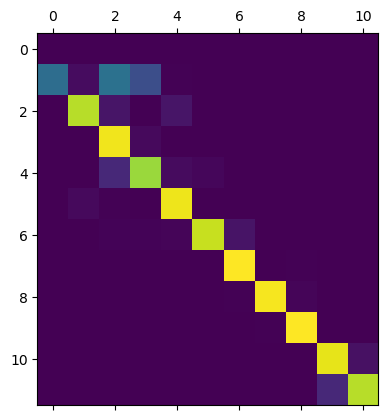

In [25]:
pair, output_phonemes, decoder_attns = evaluate_randomly()
plt.matshow(decoder_attns.numpy())